In [124]:
import sys
sys.path.append('../')

from nonlinear_system.ct_system import ContinuousTimeSystem
from nonlinear_system.epidem_odes import UIV
from moving_gauss import GaussEstimator
from lib.simulate import *
from lib.estimate import *
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy.polynomial import Polynomial as Pol

In [136]:
verbose = False
verbose_lagrange = False

num_days = 30
sampling_dt = 0.5
integration_dt = 0.01

num_integration_steps = int(num_days/integration_dt)
num_steps_per_sample = int(sampling_dt/integration_dt)

uiv_ode = UIV(beta=1, p=2)
params = {}
params["beta"] = uiv_ode.beta
params["p"] = uiv_ode.p_p
params["c"] = uiv_ode.c
params['delta'] = uiv_ode.delta

In [137]:
n = uiv_ode.n
m = uiv_ode.m
p = uiv_ode.p

U0 = 4
V0 = 50e-8
# x0 = [U0, 0, 0]
x0 = [U0, 0, V0]

nderivs = uiv_ode.nderivs

N = 6           # Number of samples in a window
n_gauss = 5     # Number of Gaussian Functions

delay = 1

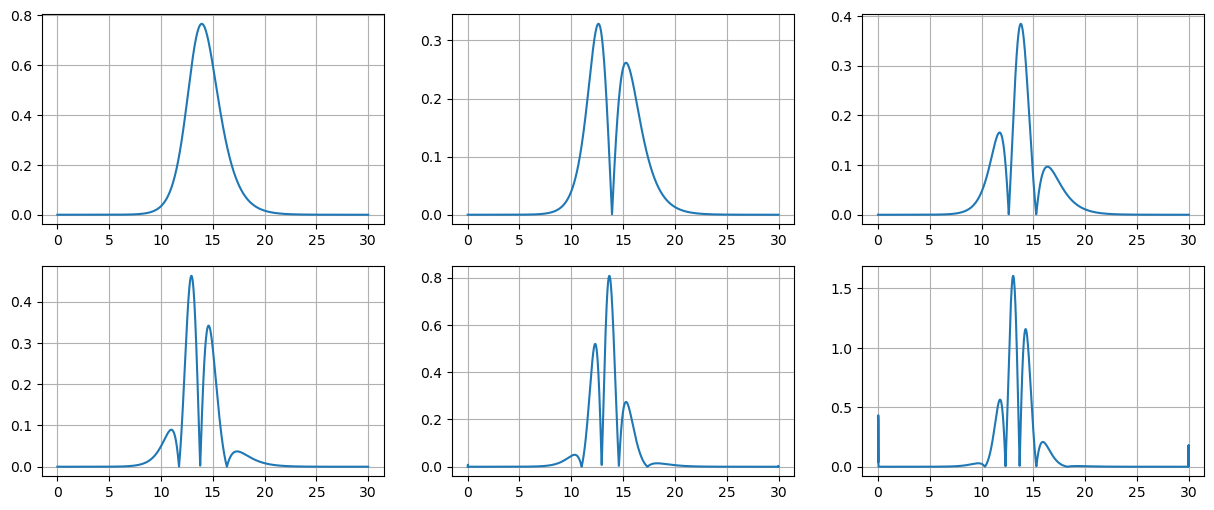

In [138]:
time, x, y_d, t_samples, y_samples = simulate(uiv_ode, x0, integration_dt, sampling_dt, num_days)

MAX_DERIVS = 5

y = [np.copy(y_d[0])]
plt.figure(figsize=(15,6))
for i in range(MAX_DERIVS+1):
    plt.subplot(2,3,i+1)
    plt.plot(time, np.abs(y[-1]))
    plt.grid()
    y.append(np.gradient(y[-1], integration_dt))
plt.show()
y = np.array(y)

In [139]:
Y_max = [0.8, 0.4, 0.4, 0.5, 0.9, 1.7]

# Polynomial Bounds
d=4
y_hat_p, y_bound_p = get_poly_estimates(t_samples, y_samples, Y_max, N, sampling_dt, d, delay, nderivs, integration_dt)

# Gaussian Bounds
y_hat_g, y_bound_g = get_gauss_estimates(t_samples, y_samples, Y_max, N, sampling_dt, n_gauss, delay, nderivs, integration_dt)

In [140]:
states2 = ["V", "I", "UV"]

x2 = uiv_ode.invert_output2(t=0, y_d=y_d)
x2_hat_g = uiv_ode.invert_output2(t=0, y_d=y_hat_g)
x2_hat_p = uiv_ode.invert_output2(t=0, y_d=y_hat_p)

x2_bound_g = uiv_ode.bound_tf(y_bound_g)
x2_bound_p = uiv_ode.bound_tf(y_bound_p)

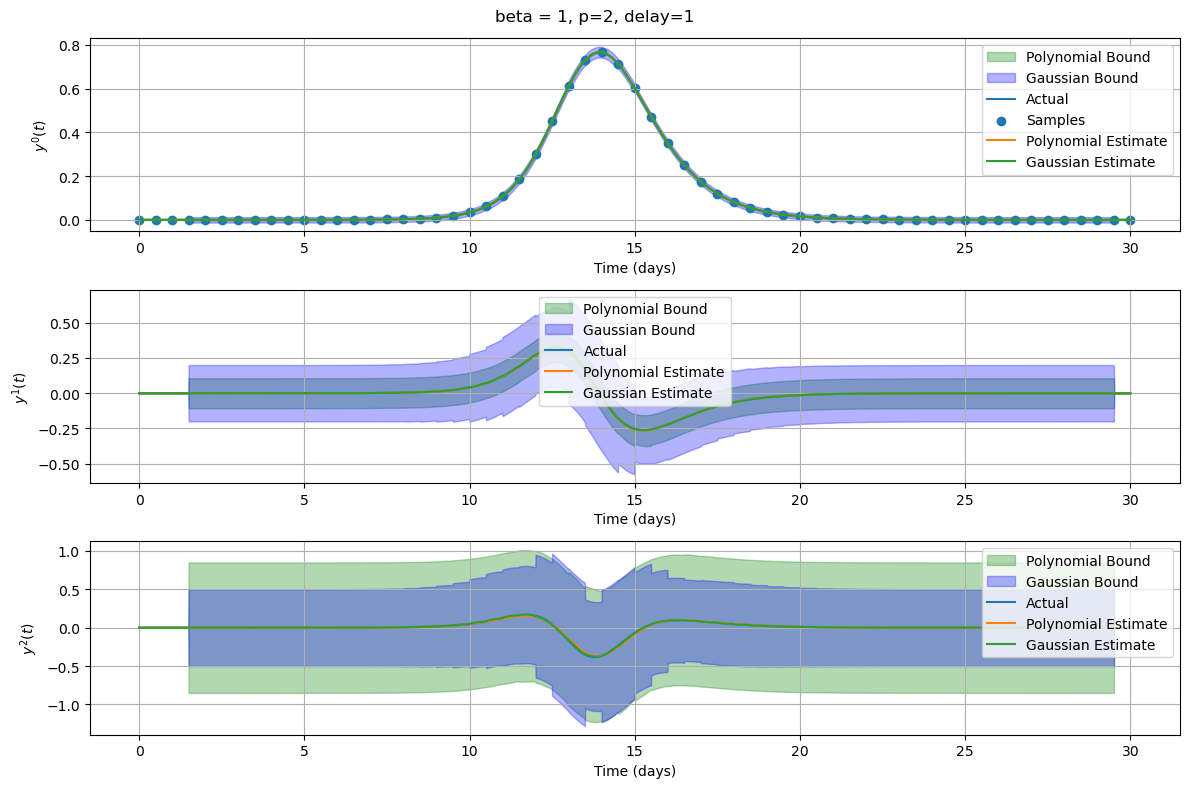

In [141]:
f2 = plt.figure("Output Derivatives", figsize=(12,8))
for derivs in range(nderivs):
    ax2 = f2.add_subplot(nderivs,1, derivs+1)
    ax2.fill_between(time, y_hat_p[derivs,:]-y_bound_p[derivs,:], y_hat_p[derivs,:]+y_bound_p[derivs,:], alpha=0.3, color='green', label='Polynomial Bound')
    ax2.fill_between(time, y_hat_g[derivs,:]-y_bound_g[derivs,:], y_hat_g[derivs,:]+y_bound_g[derivs,:], alpha=0.3, color='blue', label='Gaussian Bound')
    ax2.plot(time, y_d[derivs,:], label="Actual")
    if derivs==0:
        ax2.scatter(t_samples, y_samples, label="Samples")
    ax2.plot(time, y_hat_p[derivs,:], label="Polynomial Estimate")
    ax2.plot(time, y_hat_g[derivs,:], label="Gaussian Estimate")
    ax2.grid()
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel(f"$y^{derivs}(t)$")
    ax2.legend()
f2.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f2.tight_layout()

plt.show()

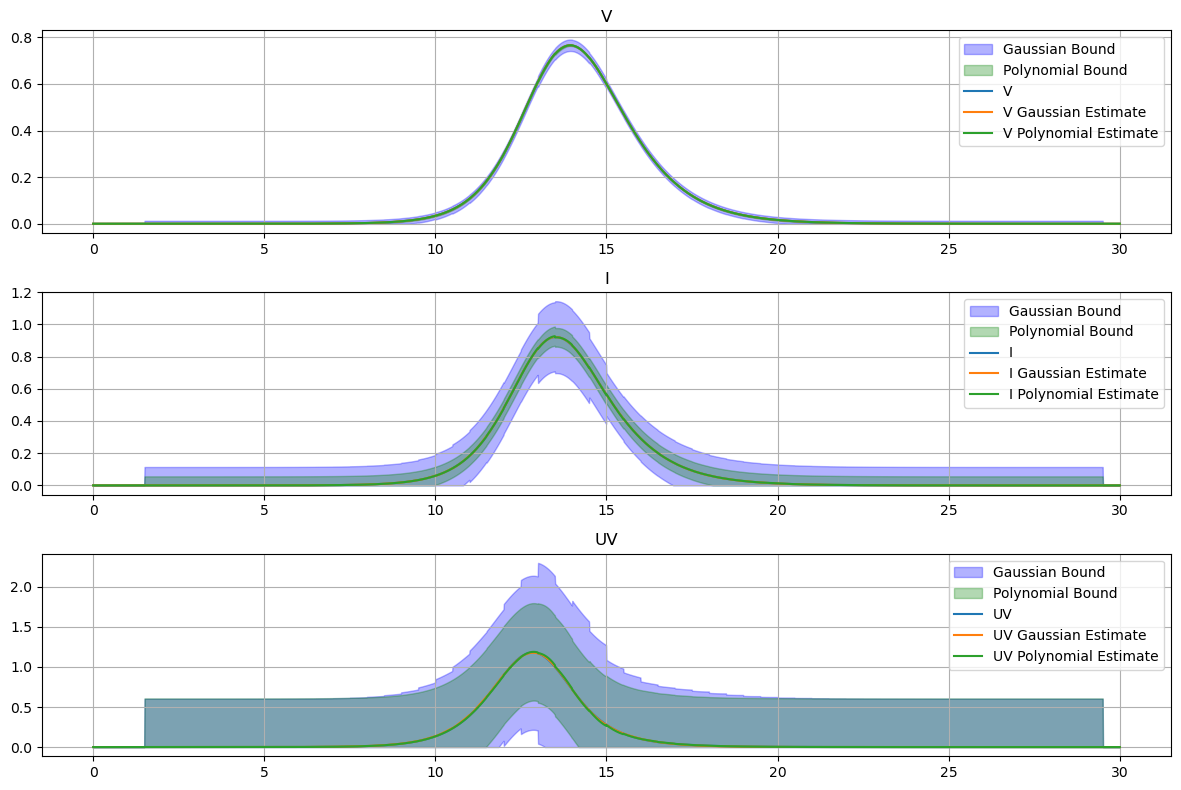

In [142]:
f3 = plt.figure("Transformed State Evolution", figsize=(12,8))
for i in range(n):
    ax = f3.add_subplot(n,1,i+1)
    ax.fill_between(time, np.maximum(0, x2_hat_g[i,:]-x2_bound_g[i,:]), x2_hat_g[i,:]+x2_bound_g[i,:], alpha=0.3, color='blue', label='Gaussian Bound')
    ax.fill_between(time, np.maximum(0, x2_hat_p[i,:]-x2_bound_p[i,:]), x2_hat_p[i,:]+x2_bound_p[i,:], alpha=0.3, color='green', label='Polynomial Bound')
    ax.plot(time, x2[i,:], label=states2[i])
    ax.plot(time, x2_hat_g[i,:], label=states2[i]+" Gaussian Estimate")
    ax.plot(time, x2_hat_p[i,:], label=states2[i]+" Polynomial Estimate")
    ax.set_title(states2[i])
    ax.grid()
    ax.legend()
# f3.suptitle(f"beta = {params['beta']}, p={params['p']}, delay={delay}")
f3.tight_layout()

## Stepwise Estimation

In [147]:
v_samples = y_samples

method1='pol'

if method1=='pol':
    print("Using Polynomials first")
    y_hat=y_hat_p
    y_bound = y_bound_p
else:
    print("Using Gaussians first")
    y_hat = y_hat_g
    y_bound = y_bound_g

v_hat_dot_samples = y_hat[1,::num_steps_per_sample]

I_hat_0 = (y_hat[1] + params['c']*y_hat[0])/params['p']
I_tilda_samples = (v_hat_dot_samples + params['c']*v_samples)/params['p']
# I_samples = x[1,::num_steps_per_sample]

E_I = np.max(y_bound[1]/params['p'])
print(f"Measurement Noise of I = {E_I}")

Using Polynomials first
Measurement Noise of I = 0.056235823244269914


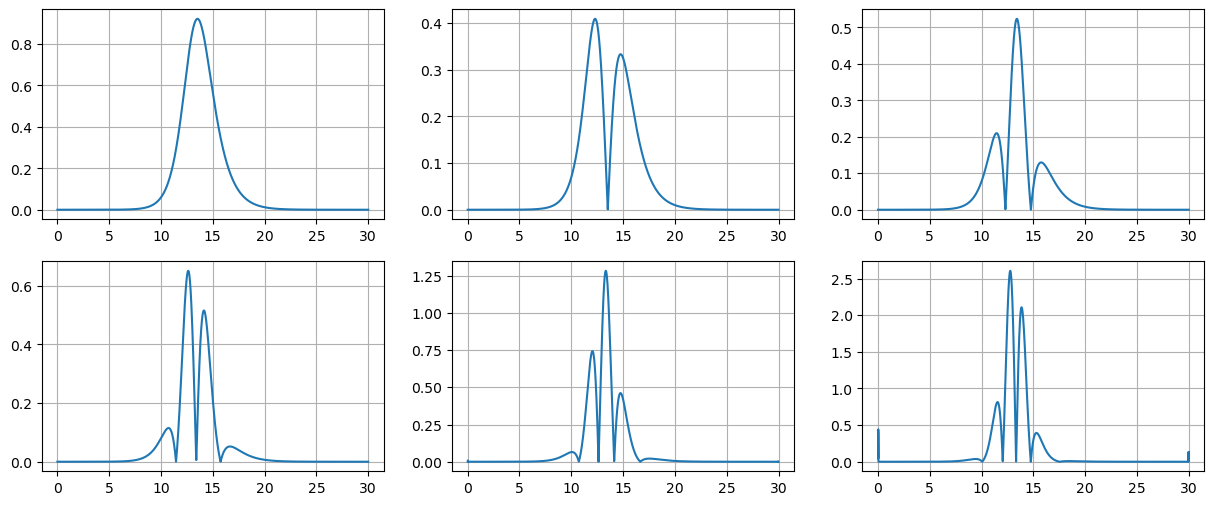

[ 0.92143007  0.40901769  0.52329214  0.65023485  1.28203203  2.60679187
 41.93789498]


In [148]:
I = x[1]

MAX_DERIVS = 5

I_d = [np.copy(I)]
plt.figure(figsize=(15,6))
for i in range(MAX_DERIVS+1):
    plt.subplot(2,3,i+1)
    plt.plot(time, np.abs(I_d[-1]))
    plt.grid()
    I_d.append(np.gradient(I_d[-1], integration_dt))
plt.show()
I_d = np.array(I_d)

print(np.max(np.abs(I_d), axis=1))

I_d_max = [1, 0.5, 0.6, 0.7, 1.3, 2.7, 42]

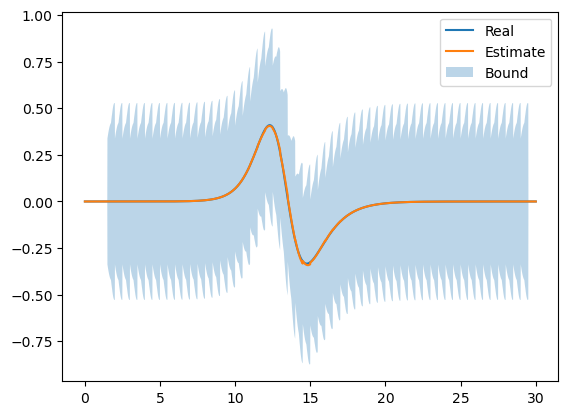

In [149]:
d = 4
I_hat, I_bound = get_poly_estimates(t_samples, I_tilda_samples, I_d_max, N, sampling_dt, d, delay, 2, integration_dt, E=E_I)

k = 1
plt.plot(time, I_d[k], label="Real")
plt.plot(time, I_hat[k], label="Estimate")
plt.fill_between(time, I_hat[k]-I_bound[k], I_hat[k]+I_bound[k], alpha=0.3, label="Bound")
plt.legend()
plt.show()

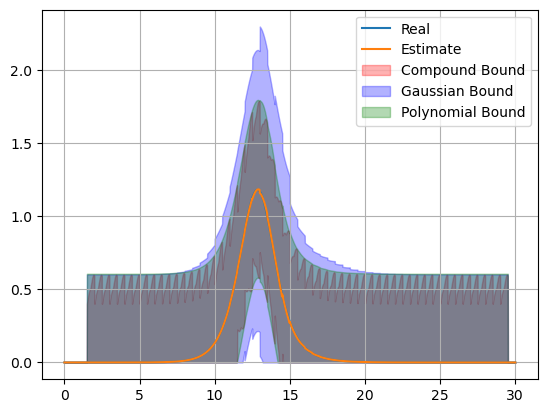

In [152]:
UV_hat = (I_hat[1]+params['delta']*I_hat[0])/params['beta']
UV_bound = (I_bound[1]+params['delta']*I_bound[0])/params['beta']

plt.plot(time, x2[2], label="Real")
plt.plot(time, UV_hat, label="Estimate")
plt.fill_between(time, np.maximum(0,UV_hat-UV_bound), np.maximum(0,UV_hat+UV_bound), alpha=0.3, color='red', label="Compound Bound")
i=2
plt.fill_between(time, np.maximum(0, x2_hat_g[i,:]-x2_bound_g[i,:]), x2_hat_g[i,:]+x2_bound_g[i,:], alpha=0.3, color='blue', label='Gaussian Bound')
plt.fill_between(time, np.maximum(0, x2_hat_p[i,:]-x2_bound_p[i,:]), x2_hat_p[i,:]+x2_bound_p[i,:], alpha=0.3, color='green', label='Polynomial Bound')

plt.legend()
plt.grid()
plt.show()